In [ ]:
from datetime import datetime, timedelta
from pathlib import Path

import h5netcdf
import numpy as np
import polars as pl

In [ ]:
DATAROOT = Path("../data")

GEOEM_FILE = DATAROOT.joinpath("src", "geo_em.d01.nc")
with h5netcdf.File(GEOEM_FILE, "r") as f:
    lon = np.array(f.variables["XLONG_M"][0, 0, :], dtype=np.float64)
    lat = np.array(f.variables["XLAT_M"][0, :, 0], dtype=np.float64)
    hgt = np.array(f.variables["HGT_M"][0, :, :], dtype=np.float32)

WEIGHT_FILE = DATAROOT.joinpath("rivnet_weight_domain.parquet")
rivnet = pl.read_parquet(WEIGHT_FILE)

In [3]:
mask = np.zeros((len(lat), len(lon)), dtype=np.uint8)

In [ ]:
for latidx, lonidx in (
    rivnet.filter(pl.col("gauge") == "Nuxia")
    .select(pl.col("latidx"), pl.col("lonidx"))
    .iter_rows()
):
    for i, j in zip(latidx, lonidx):
        mask[i, j] = 4

for latidx, lonidx in (
    rivnet.filter(pl.col("gauge") == "Yangcun")
    .select(pl.col("latidx"), pl.col("lonidx"))
    .iter_rows()
):
    for i, j in zip(latidx, lonidx):
        mask[i, j] = 3

for latidx, lonidx in (
    rivnet.filter(pl.col("gauge") == "Nugesha")
    .select(pl.col("latidx"), pl.col("lonidx"))
    .iter_rows()
):
    for i, j in zip(latidx, lonidx):
        mask[i, j] = 2


for latidx, lonidx in (
    rivnet.filter(pl.col("gauge") == "Lazi")
    .select(pl.col("latidx"), pl.col("lonidx"))
    .iter_rows()
):
    for i, j in zip(latidx, lonidx):
        mask[i, j] = 1


mask[198:205, 345:358] = np.where(
    mask[198:205, 345:358] == 0, 3, mask[198:205, 345:358]
)
mask[213:217, 253:255] = 2
mask[213, 253] = 2
mask[233:238, 132:136] = 1

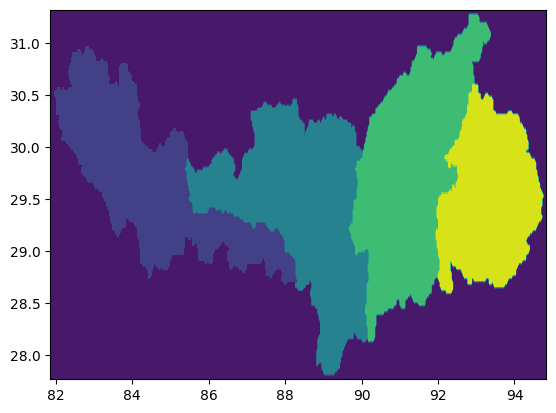

In [ ]:
latslice = slice(162, 287)
lonslice = slice(92, 487)
import matplotlib.pyplot as plt

plt.contourf(lon[lonslice], lat[latslice], mask[latslice, lonslice])


In [ ]:
with h5netcdf.File(DATAROOT.joinpath("src", "surface_01.nc")) as f:
    pr1 = (
        f.variables["RAINC"][:, latslice, lonslice]
        + f.variables["RAINNC"][:, latslice, lonslice]
    )
    rsrf1 = f.variables["SFROFF"][:, latslice, lonslice]
    rsub1 = f.variables["UDROFF"][:, latslice, lonslice]

In [ ]:
with h5netcdf.File(DATAROOT.joinpath("src", "surface_02.nc")) as f:
    pr2 = (
        f.variables["RAINC"][:, latslice, lonslice]
        + f.variables["RAINNC"][:, latslice, lonslice]
    )
    rsrf2 = f.variables["SFROFF"][:, latslice, lonslice]
    rsub2 = f.variables["UDROFF"][:, latslice, lonslice]

In [ ]:
with h5netcdf.File(DATAROOT.joinpath("src", "surface_03.nc")) as f:
    pr3 = (
        f.variables["RAINC"][:, latslice, lonslice]
        + f.variables["RAINNC"][:, latslice, lonslice]
    )
    rsrf3 = f.variables["SFROFF"][:, latslice, lonslice]
    rsub3 = f.variables["UDROFF"][:, latslice, lonslice]

In [ ]:
with h5netcdf.File(DATAROOT.joinpath("src", "surface_04.nc")) as f:
    pr4 = (
        f.variables["RAINC"][:, latslice, lonslice]
        + f.variables["RAINNC"][:, latslice, lonslice]
    )
    rsrf4 = f.variables["SFROFF"][:, latslice, lonslice]
    rsub4 = f.variables["UDROFF"][:, latslice, lonslice]

In [ ]:
with h5netcdf.File(DATAROOT.joinpath("src", "surface_05.nc")) as f:
    tm = [datetime(2000, 1, 1) + timedelta(seconds=x) for x in f.variables["time"][:]]
    pr5 = (
        f.variables["RAINC"][:, latslice, lonslice]
        + f.variables["RAINNC"][:, latslice, lonslice]
    )
    rsrf5 = f.variables["SFROFF"][:, latslice, lonslice]
    rsub5 = f.variables["UDROFF"][:, latslice, lonslice]

In [ ]:
with h5netcdf.File(DATAROOT.joinpath("src", "precip_hourly_wrf.nc")) as f:
    dtgpm = [
        datetime(2013, 5, 31, 17) + timedelta(hours=int(x))
        for x in f.variables["time"][:]
    ]
    gpm = f.variables["GPM"][:, latslice, lonslice] / 3600.0

In [ ]:
with h5netcdf.File(DATAROOT.joinpath("wrf_domain.nc"), "w") as f:
    f.attrs.update(
        {
            np.bytes_("title", "ascii"): np.bytes_("WRF domain", "ascii"),
            np.bytes_("source", "ascii"): np.bytes_("WPS version 4.3.1", "ascii"),
            np.bytes_("author", "ascii"): np.bytes_("ZHENG, Hui", "ascii"),
            np.bytes_("contact", "ascii"): np.bytes_("zhenghui@tea.ac.cn", "ascii"),
            np.bytes_("history", "ascii"): np.bytes_("Created on 2024-07-24", "ascii"),
            np.bytes_("institution", "ascii"): np.bytes_(
                "Institute of Atmospheric Physics, CAS", "ascii"
            ),
        }
    )
    f.dimensions = {"lat": len(lat), "lon": len(lon)}
    (
        f.create_variable(
            "lat", ("lat",), dtype=np.float64, compression="gzip", data=lat
        ).attrs.update(
            {
                np.bytes_("standard_name", "ascii"): np.bytes_("latitude", "ascii"),
                np.bytes_("units", "ascii"): np.bytes_("degrees_north", "ascii"),
            }
        )
    )
    (
        f.create_variable(
            "lon", ("lon",), dtype=np.float64, compression="gzip", data=lon
        ).attrs.update(
            {
                np.bytes_("standard_name", "ascii"): np.bytes_("longitude", "ascii"),
                np.bytes_("units", "ascii"): np.bytes_("degrees_east", "ascii"),
            }
        )
    )
    (
        f.create_variable(
            "HGT", ("lat", "lon"), dtype=np.float32, compression="gzip", data=hgt
        ).attrs.update(
            {
                np.bytes_("standard_name", "ascii"): np.bytes_(
                    "surface_altitude", "ascii"
                ),
                np.bytes_("units", "ascii"): np.bytes_("m", "ascii"),
            }
        )
    )

In [ ]:
def positivefloat32touint16(data, FILLVALUE, MAXVALUE):
    mask = np.isnan(data)
    scale = float(np.nanmax(data) / MAXVALUE)
    out = np.empty_like(data, dtype=np.uint16)
    out[mask] = FILLVALUE
    out[~mask] = np.array(
        np.clip(np.rint(data[~mask] / scale), 0, MAXVALUE), dtype=np.uint16
    )
    return out, scale

In [ ]:
DATETIME_REF = datetime(2000, 1, 1)

with h5netcdf.File(DATAROOT.joinpath("wrf_experiment.nc"), "w") as f:
    f.attrs.update(
        {
            np.bytes_("title", "ascii"): np.bytes_("WRF experiment", "ascii"),
            np.bytes_("source", "ascii"): np.bytes_("WRF version 4.3.1", "ascii"),
            np.bytes_("author", "ascii"): np.bytes_("ZHENG, Hui", "ascii"),
            np.bytes_("contact", "ascii"): np.bytes_("zhenghui@tea.ac.cn", "ascii"),
            np.bytes_("history", "ascii"): np.bytes_("Created on 2024-07-24", "ascii"),
            np.bytes_("institution", "ascii"): np.bytes_(
                "Institute of Atmospheric Physics, CAS", "ascii"
            ),
            np.bytes_("comment", "ascii"): np.bytes_(
                f"range of latitude index in the original domain: [{latslice.start}-{latslice.stop + 1}]\nrange of longitude index in the original domain: [{lonslice.start}-{lonslice.stop + 1}]",
                "ascii",
            ),
        }
    )
    f.dimensions = {
        "time": None,
        "lat": len(lat[latslice]),
        "lon": len(lon[lonslice]),
        "ensemble": 5,
    }
    f.resize_dimension("time", len(tm))
    (
        f.create_variable(
            "time",
            ("time",),
            dtype=np.float64,
            compression="gzip",
            data=[(x - DATETIME_REF).total_seconds() for x in tm],
        ).attrs.update(
            {
                np.bytes_("units", "ascii"): np.bytes_(
                    f"seconds since {DATETIME_REF.isoformat()}Z", "ascii"
                )
            }
        )
    )
    (
        f.create_variable(
            "lat", ("lat",), dtype=np.float64, compression="gzip", data=lat[latslice]
        ).attrs.update(
            {
                np.bytes_("units", "ascii"): np.bytes_("degrees_north", "ascii"),
                np.bytes_("standard_name", "ascii"): np.bytes_("latitude", "ascii"),
            }
        )
    )
    (
        f.create_variable(
            "lon", ("lon",), dtype=np.float64, compression="gzip", data=lon[lonslice]
        ).attrs.update(
            {
                np.bytes_("units", "ascii"): np.bytes_("degrees_east", "ascii"),
                np.bytes_("standard_name", "ascii"): np.bytes_("longitude", "ascii"),
            }
        )
    )
    (
        f.create_variable(
            "mask",
            (
                "lat",
                "lon",
            ),
            dtype=np.uint8,
            compression="gzip",
            fillvalue=0,
            data=mask[latslice, lonslice],
        ).attrs.update(
            {
                np.bytes_("long_name", "ascii"): np.bytes_(
                    "gauge station flag", "ascii"
                ),
                np.bytes_("flag_masks", "ascii"): np.array(
                    [1, 2, 3, 4], dtype=np.uint8
                ),
                np.bytes_("flag_meanings", "ascii"): np.bytes_(
                    "Lazi Nugesha Yangcun Nuxia", "ascii"
                ),
            }
        )
    )

    pr = np.stack((pr1, pr2, pr3, pr4, pr5), axis=0)
    pr[
        np.broadcast_to(
            np.expand_dims(
                np.expand_dims(mask[latslice, lonslice] == 0, axis=0), axis=0
            ),
            pr.shape,
        )
    ] = np.nan
    (
        f.create_variable(
            "pr",
            (
                "ensemble",
                "time",
                "lat",
                "lon",
            ),
            compression="gzip",
            dtype=np.float32,
            fillvalue=np.float32(np.nan),
            data=pr,
        ).attrs.update(
            {
                np.bytes_("units", "ascii"): np.bytes_("kg m-2 s-1", "ascii"),
                np.bytes_("standard_name", "ascii"): np.bytes_(
                    "precipitation_flux", "ascii"
                ),
            }
        )
    )

    rsrf = np.stack((rsrf1, rsrf2, rsrf3, rsrf4, rsrf5), axis=0)
    rsub = np.stack((rsub1, rsub2, rsub3, rsub4, rsub5), axis=0)
    rn = rsrf + rsub
    rn[
        np.broadcast_to(
            np.expand_dims(
                np.expand_dims(mask[latslice, lonslice] == 0, axis=0), axis=0
            ),
            rn.shape,
        )
    ] = np.nan
    (
        f.create_variable(
            "mrro",
            (
                "ensemble",
                "time",
                "lat",
                "lon",
            ),
            compression="gzip",
            dtype=np.float32,
            fillvalue=np.float32(np.nan),
            data=rn,
        ).attrs.update(
            {
                np.bytes_("units", "ascii"): np.bytes_("kg m-2 s-1", "ascii"),
                np.bytes_("standard_name", "ascii"): np.bytes_("runoff_flux", "ascii"),
            }
        )
    )

    gpm_expand = np.full((len(tm), len(lat[latslice]), len(lon[lonslice])), np.nan)
    gpm[
        np.broadcast_to(
            np.expand_dims(mask[latslice, lonslice] == 0, axis=0), gpm.shape
        )
    ] = np.nan
    gpm_expand[tm.index(dtgpm[0]) : tm.index(dtgpm[-1]) + 1, :, :] = gpm
    (
        f.create_variable(
            "gpm",
            (
                "time",
                "lat",
                "lon",
            ),
            compression="gzip",
            dtype=np.float32,
            fillvalue=np.float32(np.nan),
            data=gpm_expand,
        ).attrs.update(
            {
                np.bytes_("units", "ascii"): np.bytes_("kg m-2 s-1", "ascii"),
                np.bytes_("standard_name", "ascii"): np.bytes_(
                    "precipitation_flux", "ascii"
                ),
            }
        )
    )
